<p style="font-size:30px; text-align:center"><b>Black-Scholes Basics</b></p>
We review the Black-Scholes model with continuous dividends. The results are presented using the Python data science stack.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
import ipywidgets as wd
from mpl_toolkits import mplot3d

import sys
sys.path.append("../../")
import pyqfin.models.black_scholes as bs

# Dynamics of the Underlying

**Definition**: The *Black-Scholes model* is defined by a stochastic process
\begin{align}
        dS_t = (r-q) S_t dt + \sigma S_t dW_t, && S_0 = s_0
\end{align}
on a probability space $(\Omega, \mathcal{F}, \mathbb{Q})$, where we think of $\mathbb{Q}$ as the risk-neutral measure with respect to a *bank account numeraire* $B(t)$ defined by
\begin{align*}
    dB_t = r B_t dt, && B_0=1
\end{align*}
Here,
* $s_0$ is the initial value for the stock
* $r \in \mathbb{R}$ is a fixed *risk-free rate*, 
* $\sigma > 0$ is the *volatility*, 
* $W_t$ is a Brownian motion,
* $S_t$ is the evolution of the stock price.


**Lemma (explicit evolution of the underlying):** In the Black-Scholes model, the stock price $S$ and the bank account numeraire $B$ have the explicit solution 
\begin{align}
    S_t & = s_0 \exp(((r-q - \tfrac{1}{2} \sigma^2)t + \sigma W_t) \\
    B_t & = \exp(rt)
\end{align}

**Corollary (distributions):** The stock price $S_t$ is log-normally distributed and for any $0 \leq t \leq T$
\begin{align*}
    \mathbb{E}[ S_T \mid \mathcal{F}_t] &= e^{S_t + (r-q)(T-t)}\\
    \mathbb{V}[S_T \mid \mathcal{F}_t] &= (e^{\sigma^2(T-t)}-1) e^{2(S_t + (r-q)(T-t)) + \sigma^2(T-t)}\\
    \operatorname{Cov}[S_t, S_T] &= s_0^2 e^{\sigma^2 \tfrac{t+T}{2}} ( e^{\sigma^2 t} - 1 )  e^{(r-q - \tfrac{1}{2}\sigma^2) (t+T)}
\end{align*}

In [3]:
params = bs.Params(sigma=0.2, r=0.03, q=0.01)

ntimes = 10
time_grid = np.linspace(0, 2, ntimes)
npaths = 100000

bsm = bs.Simulation(params, time_grid, npaths)
bsm.simulate(s0=100)

## Example Paths

<IPython.core.display.Javascript object>


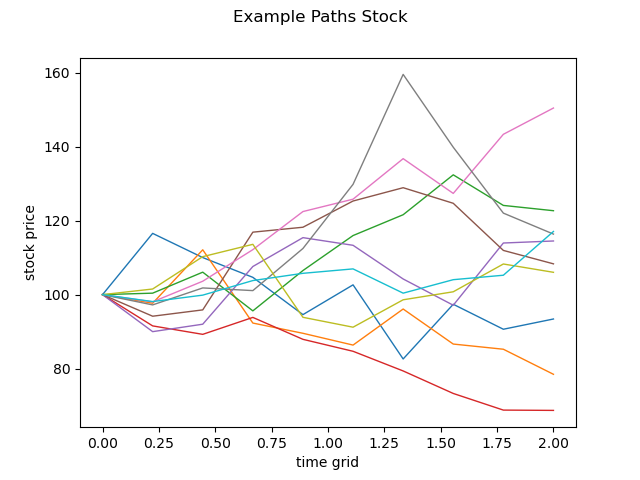

In [4]:
figpath, axpath = plt.subplots()
figpath.suptitle('Example Paths Stock')
axpath.plot(time_grid, bsm.s_[:10, :].T, lw=1)
axpath.set_xlabel('time grid')
axpath.set_ylabel('stock price')
plt.show()

## Stock Price Mean

<IPython.core.display.Javascript object>


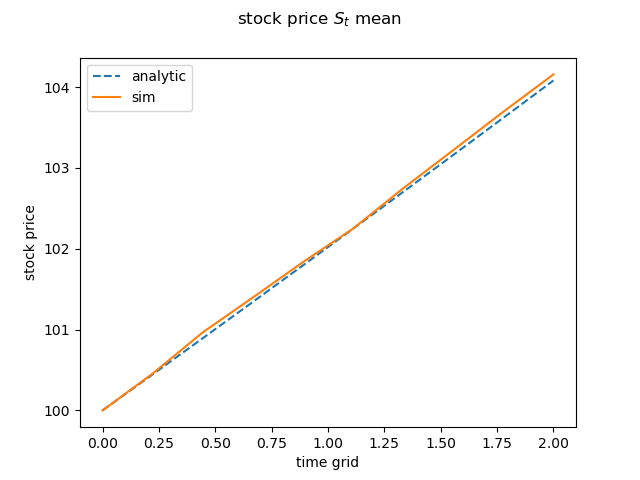

In [5]:
figmean, axmean = plt.subplots()
figmean.suptitle('stock price $S_t$ mean')
axmean.plot(time_grid, bsm.stock_means(), label='analytic', linestyle='--')
axmean.plot(time_grid, bsm.s_.mean(axis=0), label='sim')
axmean.set_xlabel('time grid')
axmean.set_ylabel('stock price')
axmean.legend()
plt.show()

## Stock Price Standard Deviation

<IPython.core.display.Javascript object>


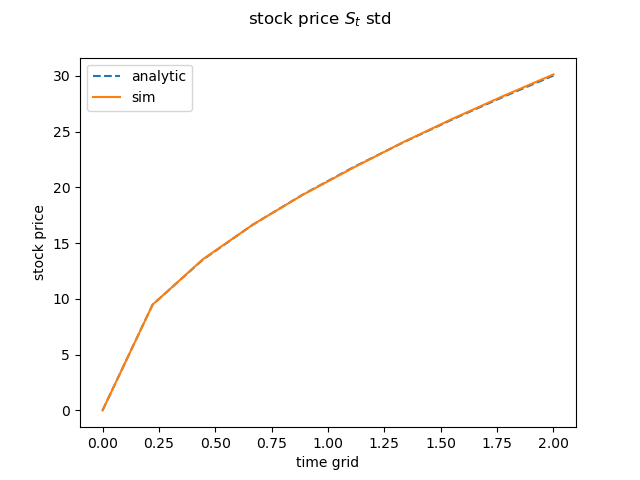

In [6]:
figvar, axvar = plt.subplots()
figvar.suptitle('stock price $S_t$ std')
axvar.plot(time_grid, np.sqrt(bsm.stock_vars()), label='analytic', linestyle='--')
axvar.plot(time_grid, bsm.s_.std(axis=0), label='sim')
axvar.set_xlabel('time grid')
axvar.set_ylabel('stock price')
axvar.legend()
plt.show()

## Stock Price Autocovariance

<IPython.core.display.Javascript object>


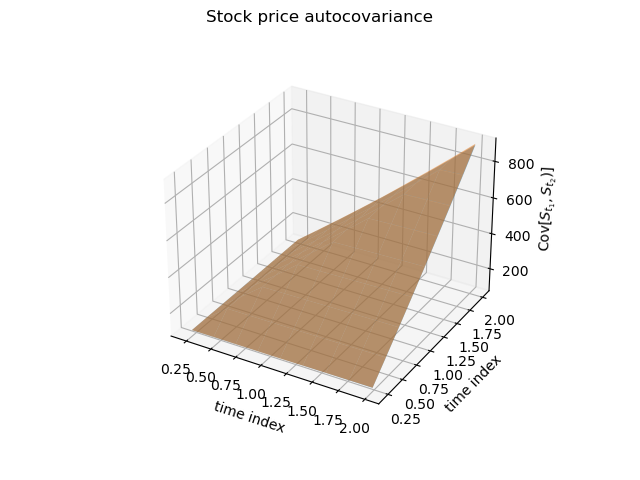

In [7]:
tx, ty = np.meshgrid(bsm.time_grid[1:], bsm.time_grid[1:])
figxcov = plt.figure()
figxcov.suptitle('Stock price autocovariance')
axxcov = plt.axes(projection="3d")
axxcov.plot_surface(tx, ty, bsm.stock_autocovs()[1:,1:], label='analytic', alpha=0.5)
axxcov.plot_surface(tx, ty, np.cov(bsm.s_[:,1:].T), label='sim', alpha=0.5)
axxcov.set_xlabel('time index')
axxcov.set_ylabel('time index')
axxcov.set_zlabel('$\operatorname{Cov}[S_{t_1}, S_{t_2})]$')
plt.show()

# Option Pricing

**Theorem (risk-neutral pricing):** Let $V_T$ be an $\mathcal{F}_T$-measurable payoff. Then the arbitrage-free price $V_t$ of $V_T$ at $t$ is given by
\begin{align*}
    V_t = e^{-r(T-t)}\mathbb{E}[V_T \mid \mathcal{F}_t].
\end{align*}

**Definition:** For any *strike* $K$ and *maturity* $T$, the payoffs
\begin{align*}
    C(T) &:= (S_T - K)^+, \\
    P(T) &:= (K-S_T)^+, \\
    F(T) &:= S_T - K
\end{align*}
are called *European call option*, *European put option* and *forward*.

A key feature of the Black-Scholes model is that the prices of options can be calculated analytically.

**Theorem**: The price of a European call option $C$, put option $P$ and Forward $F$ with maturity $T$ and strike $K$ is given by
\begin{align*}
    C_t &= e^{-r (T-t)}( f_t \Phi(d_1) - K \Phi(d_2)),\\
    P_t &= e^{-r(T-t)}(K - \Phi(d_2) - f_t \Phi(-d_1)), \\
    F_t &= e^{-q (T-t)}S_0 - e^{-r(T-t)} K, \\
    d_1 &:= \frac{1}{\sigma \sqrt{T-t}} \Big( (r-q+\tfrac{1}{2}\sigma^2)(T-t) + \ln\Big(\frac{S_0}{K}\Big) \Big)\\
    d_2 &:= d_1 - \sigma \sqrt{T-t},\\
    f_t &:= e^{(r-q)(T-t)}S_t
\end{align*}
and the put/call parity 
\begin{align*}
    C_t - P_t = e^{-q (T-t)}S_0 - e^{-r(T-t)} K
\end{align*}
holds. Here $\Phi$ denotes the CDF of the standard normal distribution.

In [8]:
strikes = np.linspace(90, 110, 10)
ti = round(time_grid.shape[0] / 2)
maturities = time_grid[ti:]
strikes_, maturities_ = np.meshgrid(strikes, maturities)
call_analytic = np.array([[bsm.analytic.price(bsm.s0, tau, k, 'c') for k in strikes] for tau in maturities])
put_analytic = np.array([[bsm.analytic.price(bsm.s0, tau, k, 'p') for k in strikes] for tau in maturities])
call_mc = np.array([[bsm.price(0, t, k, 'c').mean() for k in strikes] for t in range(ti, time_grid.shape[0])])
put_mc = np.array([[bsm.price(0, t, k, 'p').mean() for k in strikes] for t in range(ti, time_grid.shape[0])])

In [9]:
import matplotlib
matplotlib.__version__

'3.5.0'

<IPython.core.display.Javascript object>


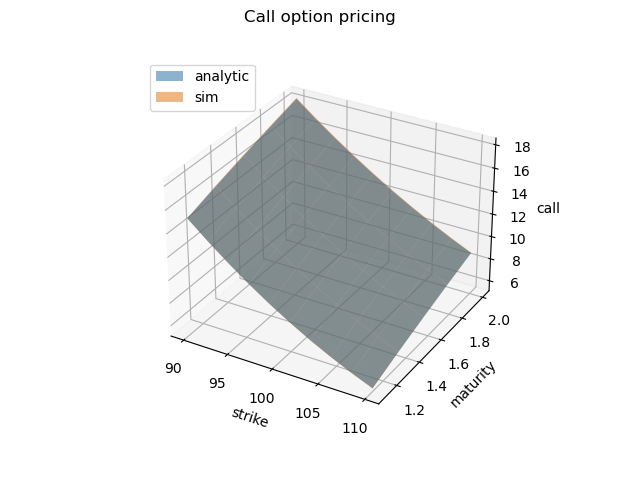

In [10]:
tx, ty = np.meshgrid(bsm.time_grid[1:], bsm.time_grid[1:])
figcall = plt.figure()
figcall.suptitle('Call option pricing')
axcall = plt.axes(projection="3d")
surf = axcall.plot_surface(strikes_, maturities_, call_analytic, label='analytic', alpha=0.5)
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
surf = axcall.plot_surface(strikes_, maturities_, call_mc, label='sim', alpha=0.5)
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
axcall.set_xlabel('strike')
axcall.set_ylabel('maturity')
axcall.set_zlabel('call')
axcall.legend(loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


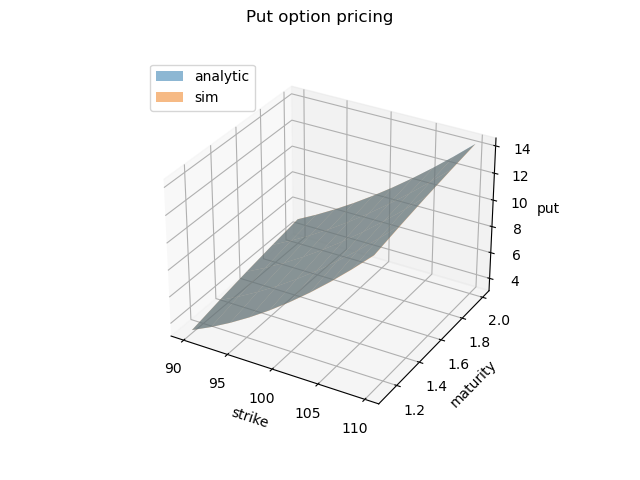

In [11]:
tx, ty = np.meshgrid(bsm.time_grid[1:], bsm.time_grid[1:])
figput = plt.figure()
figput.suptitle('Put option pricing')
axput = plt.axes(projection="3d")
surf = axput.plot_surface(strikes_, maturities_, put_analytic, label='analytic', alpha=0.5)
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
surf = axput.plot_surface(strikes_, maturities_, put_mc, label='sim', alpha=0.5)
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
axput.set_xlabel('strike')
axput.set_ylabel('maturity')
axput.set_zlabel('put')
axput.legend(loc='upper left')
plt.show()

# Greeks
The sensitivities of the option price can also be worked out analytically.

In [18]:
greeks_s0 = np.linspace(80, 120, 40)
greeks_sigma = wd.FloatSlider(min=0.01, max=0.2, value=0.02, step=0.01)
greeks_r = wd.FloatSlider(min=0., max=0.1, value=0.03, step=0.001)
greeks_q = wd.FloatSlider(min=0., max=0.1, value=0., step=0.001)
greeks_tau = wd.FloatSlider(min=0.1, max=5, value=1, step=0.1)
greeks_k = wd.FloatSlider(min=80, max=120, value=100, step=1)

## Delta

The Delta is given by
\begin{align}
    \Delta_{\text{Call}} := \frac{\partial C}{\partial S_0} = e^{-q T} \Phi(d_1), &&
    \Delta_{\text{Put}} := \frac{\partial P}{\partial S_0} = e^{-q T} (\Phi(d_1) - 1)
\end{align}

<IPython.core.display.Javascript object>


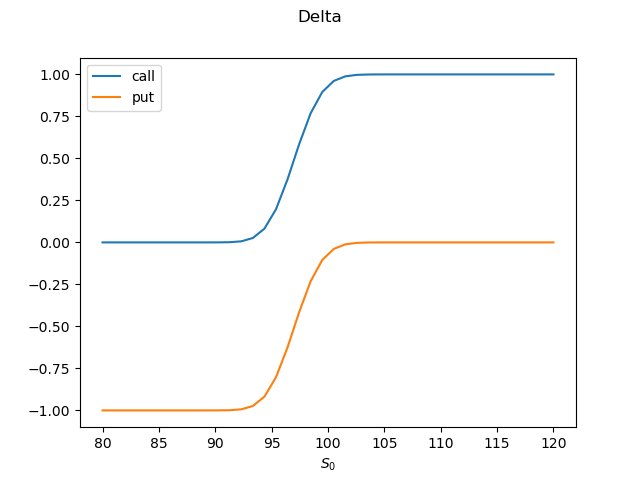

interactive(children=(FloatSlider(value=0.02, description='sigma', max=0.2, min=0.01, step=0.01), FloatSlider(…

In [19]:
fig_delta, ax_delta = plt.subplots()
fig_delta.suptitle('Delta')

@wd.interact(sigma=greeks_sigma, r=greeks_r, q=greeks_q, tau=greeks_tau, k=greeks_k)
def plot_delta(sigma, r, q, tau, k):
    ax_delta.clear()
    a = bs.Analytic.fromParamValues(sigma, r, q)
    ax_delta.plot(greeks_s0, a.delta(greeks_s0, tau, k, 'c'), label='call')
    ax_delta.plot(greeks_s0, a.delta(greeks_s0, tau, k, 'p'), label='put')
    ax_delta.set_xlabel('$S_0$')
    ax_delta.set_ylim([-1.1, 1.1])
    ax_delta.legend()

## Gamma
The gamma is given by
\begin{align}
    \Gamma := \frac{\partial^2 C}{\partial S_0^2} = e^{-q T} \frac{\varphi(d_1)}{\sigma \sqrt{T}} = \frac{\partial^2 P}{\partial S_0^2}
\end{align}

<IPython.core.display.Javascript object>


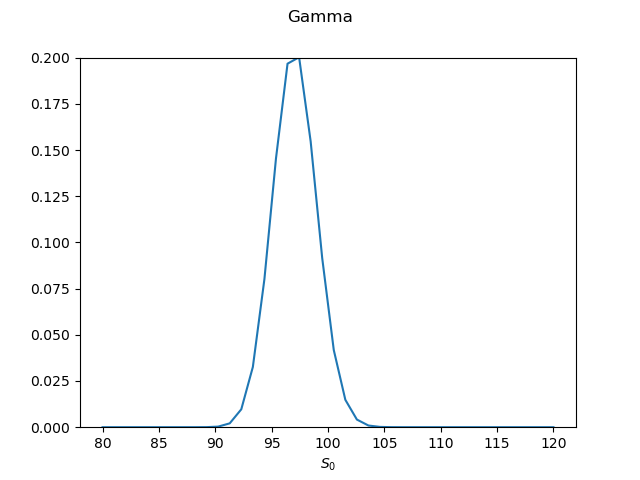

interactive(children=(FloatSlider(value=0.02, description='sigma', max=0.2, min=0.01, step=0.01), FloatSlider(…

In [20]:
fig_gamma, ax_gamma = plt.subplots()
fig_gamma.suptitle('Gamma')

@wd.interact(sigma=greeks_sigma, r=greeks_r, q=greeks_q, tau=greeks_tau, k=greeks_k)
def plot_gamma(sigma, r, q, tau, k):
    ax_gamma.clear()
    a = bs.Analytic.fromParamValues(sigma, r, q)
    ax_gamma.plot(greeks_s0, a.gamma(greeks_s0, tau, k))
    ax_gamma.set_xlabel('$S_0$')
    ax_gamma.set_ylim([0, 0.2])

## Vega
The Vega is given by
\begin{align}
    \mathcal{V} := \frac{\partial C}{\partial \sigma} = e^{-q T} S_0 \varphi(d_1) \sqrt{T} =
    \frac{\partial P}{\partial \sigma}
\end{align}

<IPython.core.display.Javascript object>


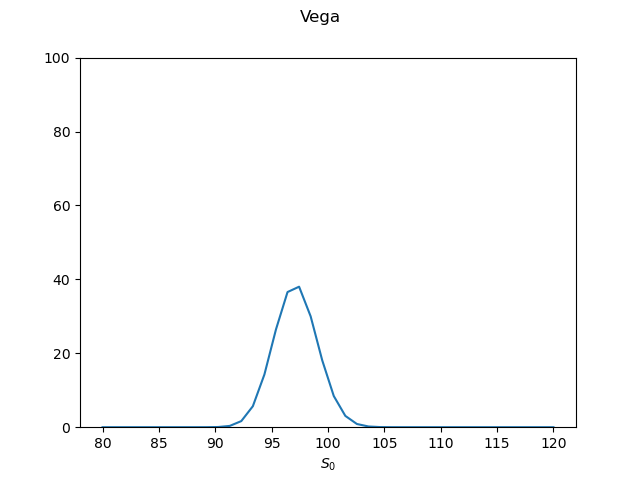

interactive(children=(FloatSlider(value=0.02, description='sigma', max=0.2, min=0.01, step=0.01), FloatSlider(…

In [21]:
fig_vega, ax_vega = plt.subplots()
fig_vega.suptitle('Vega')

@wd.interact(sigma=greeks_sigma, r=greeks_r, q=greeks_q, tau=greeks_tau, k=greeks_k)
def plot_vega(sigma, r, q, tau, k):
    ax_vega.clear()
    a = bs.Analytic.fromParamValues(sigma, r, q)
    ax_vega.plot(greeks_s0, a.vega(greeks_s0, tau, k))
    ax_vega.set_xlabel('$S_0$')
    ax_vega.set_ylim([0, 100])

## Theta
The Theta is given by
\begin{align}
    \Theta_{\text{Call}} &:= 
    \frac{\partial C}{\partial t} 
    = q e^{-q(T-t)}S_0 \Phi(d_1) - r e^{-r(T-t)} K \Phi(d_2) - e^{-q(T-t)}\frac{\sigma S_0 \varphi(d_1)}{2 \sqrt{T-t}}, \\
    \Theta_{\text{Put}} &:= 
    \frac{\partial P}{\partial t}
    = \frac{\partial C}{\partial t} -qe^{-q(T-t)}S_0 + r e^{-r(T-t)} K
\end{align}

<IPython.core.display.Javascript object>


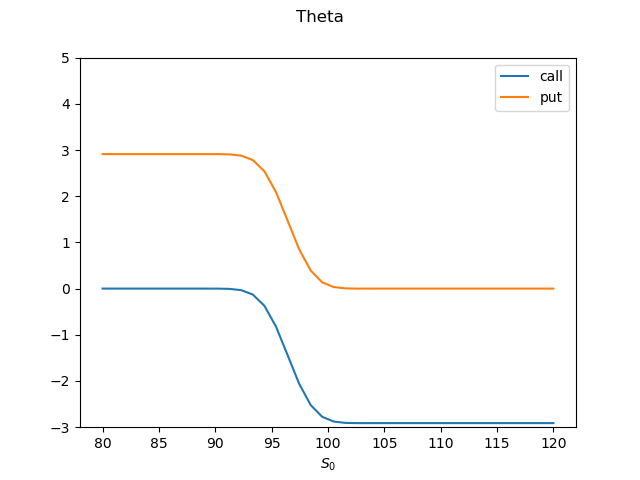

interactive(children=(FloatSlider(value=0.02, description='sigma', max=0.2, min=0.01, step=0.01), FloatSlider(…

In [22]:
fig_theta, ax_theta = plt.subplots()
fig_theta.suptitle('Theta')

@wd.interact(sigma=greeks_sigma, r=greeks_r, q=greeks_q, tau=greeks_tau, k=greeks_k)
def plot_theta(sigma, r, q, tau, k):
    ax_theta.clear()
    a = bs.Analytic.fromParamValues(sigma, r, q)
    ax_theta.plot(greeks_s0, a.theta(greeks_s0, tau, k, 'c'), label='call')
    ax_theta.plot(greeks_s0, a.theta(greeks_s0, tau, k, 'p'), label='put')
    ax_theta.set_xlabel('$S_0$')
    ax_theta.set_ylim([-3, 5])
    ax_theta.legend()

## Rho
The Rho is given by
\begin{align}
    \rho_{\text{Call}} := \frac{\partial C}{\partial r} = T e^{-r T} K \Phi(d_2), &&
    \rho_{\text{Put}} := \frac{\partial P}{\partial r}  &=-T e^{-r T} K \Phi(-d_2)
\end{align}

<IPython.core.display.Javascript object>


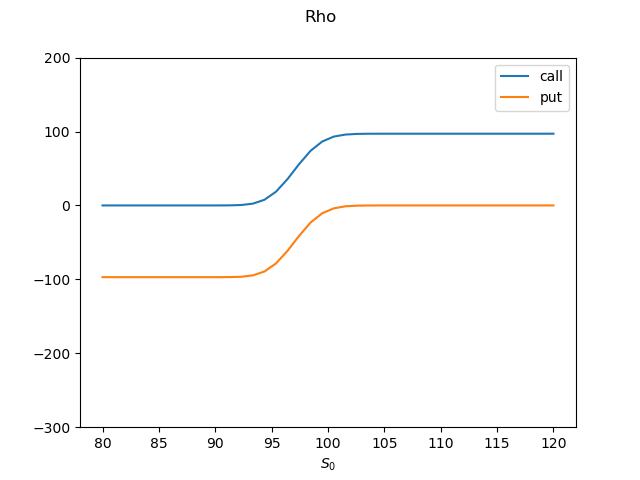

interactive(children=(FloatSlider(value=0.02, description='sigma', max=0.2, min=0.01, step=0.01), FloatSlider(…

In [23]:
fig_rho, ax_rho = plt.subplots()
fig_rho.suptitle('Rho')

@wd.interact(sigma=greeks_sigma, r=greeks_r, q=greeks_q, tau=greeks_tau, k=greeks_k)
def plot_theta(sigma, r, q, tau, k):
    ax_rho.clear()
    a = bs.Analytic.fromParamValues(sigma, r, q)
    ax_rho.plot(greeks_s0, a.rho(greeks_s0, tau, k, 'c'), label='call')
    ax_rho.plot(greeks_s0, a.rho(greeks_s0, tau, k, 'p'), label='put')
    ax_rho.set_xlabel('$S_0$')
    ax_rho.set_ylim([-300, 200])
    ax_rho.legend()